<a href="https://colab.research.google.com/github/AmirHDehghan/AI_MED_Internship/blob/main/DCGAN/MNIST/MyFirstDCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.autograd import Variable

from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image
from torch.utils.data import Dataset, DataLoader
# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
#print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

In [40]:
# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 20

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [41]:
trainf_data = dset.MNIST(root = './data', train = True,
                        transform = transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5), (0.5)),
                           ]), download = True)

train_data = dset.MNIST(root = './data', train = True,
                       transform = transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                              
                               transforms.ToTensor(),
                               transforms.Normalize((0.5), (0.5)),
                           ]))

In [42]:
train_loader = torch.utils.data.DataLoader(trainf_data, batch_size=batch_size,
                                         shuffle=True, num_workers=0)
# test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
#                                          shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

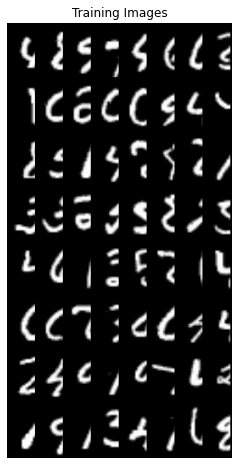

In [81]:
# Plot some training images
#transforms.functional.crop(test_loader,0,0,14,14)
real_batch = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [43]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [98]:
class Generator(nn.Module):
  def __init__(self,ngpu):
    super(Generator,self).__init__()
    self.ngpu = ngpu

    self.embedder = nn.Sequential(
        
        #image to 1st feature map
        nn.Conv2d(nc,ndf,4,2,1,bias=False),  
        nn.BatchNorm2d(ndf),
        nn.LeakyReLU(0.2,inplace=False),
        #1st feature map to 2nd
        nn.Conv2d(ndf,ndf*2,4,2,1,bias=False),
        nn.BatchNorm2d(ndf*2),
        nn.LeakyReLU(0.2,inplace=False),
        #2nd feature map to 3rd
        nn.Conv2d(ndf*2,ndf*4,4,2,1,bias=False),
        nn.BatchNorm2d(ndf*4),
        nn.LeakyReLU(0.2,inplace=False),

        nn.Flatten(),
        nn.Dropout(0.25),
        nn.Linear((ndf*4)*4*8, 128),
        nn.Linear(128, nz)
    )

    self.main = nn.Sequential(
        # z to first conv
        nn.ConvTranspose2d(nz*2,ngf*8,(4,2),1,0,bias=False),  
        nn.BatchNorm2d(ngf*8),
        nn.ReLU(False),
        # 1st conv to 2nd
        nn.ConvTranspose2d(ngf*8,ngf*4,4,2,1,bias=False),
        nn.BatchNorm2d(ngf*4),
        nn.ReLU(False),
        # 2st conv to 3rd
        nn.ConvTranspose2d(ngf*4,ngf*2,4,2,1,bias=False),
        nn.BatchNorm2d(ngf*2),
        nn.ReLU(False),
        # 3st conv to 4th
        nn.ConvTranspose2d(ngf*2,ngf,4,2,1,bias=False),
        nn.BatchNorm2d(ngf),
        nn.ReLU(False),

        nn.ConvTranspose2d(ngf,nc,4,2,1,bias=False),
        nn.Tanh()
    )
    #print(self.main.shape)
  def forward(self,input_vector,input_image):
    embedded = self.embedder(input_image)
    # print(embedded.shape,input_vector.shape)
    output_vector = torch.cat([input_vector,embedded[:,:,None,None]],dim=1)
    return self.main(output_vector)

In [99]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))



# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

if torch.cuda.is_available():
    netG.cuda()

In [91]:
class Discriminator(nn.Module):
  def __init__(self,ngpu):
    super(Discriminator,self).__init__()
    self.ngpu = ngpu
    self.main = nn.Sequential(
        #image to 1st feature map
        nn.Conv2d(nc,ndf,4,2,1,bias=False),
        nn.LeakyReLU(0.2,inplace=False),
        #1st feature map to 2nd
        nn.Conv2d(ndf,ndf*2,4,2,1,bias=False),
        nn.BatchNorm2d(ndf*2),
        nn.LeakyReLU(0.2,inplace=False),
        #2nd feature map to 3rd
        nn.Conv2d(ndf*2,ndf*4,4,2,1,bias=False),
        nn.BatchNorm2d(ndf*4),
        nn.LeakyReLU(0.2,inplace=False),
        #3rd feature map to 4th
        nn.Conv2d(ndf*4,ndf*8,4,2,1,bias=False),
        nn.BatchNorm2d(ndf*8),
        nn.LeakyReLU(0.2,inplace=False),
        #4th to One!
        nn.Conv2d(ndf*8,1,4,1,0,bias=False),
        nn.Sigmoid()
    )
  
  def forward(self,input):   
    return self.main(input)

In [92]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

if torch.cuda.is_available():
    netD.cuda()


In [100]:
# Initializing Loss!
criterion = nn.BCELoss().to(device)

# Generating noise
fixed_noise = torch.rand(128,nz,1,1,device=device)


real_label = 1.
fake_label = 0.
# Optimizer Initialization
OptimizerG = optim.Adam(netG.parameters(),lr=lr,betas=(beta1,0.999))
OptimizerD =optim.Adam(netD.parameters(),lr=lr,betas=(beta1,0.999))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Training!

In [104]:
#Training Phase

# Keeping Track...
img_list= []
imagel=[]
D_losses= []
G_losses= []
sen=[]
spec=[]
iters= 0

# The Loop:
for epoch in range(25):
  # Each epoch:
  for i, image in enumerate(train_loader,1):

    real_cpu = image[0].to(device)
    real_cpu_half = real_cpu[:,:,:,:32]
    b_size = real_cpu.size(0)
    noise = torch.randn(b_size, nz, 1, 1, device=device)
    label = torch.full((b_size,),real_label,dtype=torch.float,device=device)

  
  # Update D-Network
  # Update real batches
    if i%10==0: 
      netD.zero_grad()
      output = netD(real_cpu).view(-1)
      err_D_real = criterion(output,label)
      err_D_real.backward()

      # Update fake batches

      fake = netG(noise,real_cpu_half)
      label.fill_(fake_label)
      complete_image = torch.cat([fake,real_cpu[:,:,:,32:]],dim=3)
      output = netD(complete_image).view(-1)
      err_D_fake = criterion(output,label)
      err_D_fake.backward()
      errD = err_D_real + err_D_fake

      OptimizerD.step()
    else:
      pass
  
    # Update G-Network
    
    netG.zero_grad()
    # Generate fake image batch with G
    fake = netG(noise,real_cpu_half)
    label.fill_(real_label)
    complete_image2 = torch.cat([fake,real_cpu[:,:,:,32:]],dim=3)
    output = netD(complete_image2).view(-1)
    errG = criterion(output,label)
    errG.backward()
      
    OptimizerG.step()

    #if i % 50 == 0:
     #       print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
      #            % (epoch, num_epochs, i, len(train_loader),
       #              errD.item(), errG.item()))
    if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(train_loader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise,real_cpu_half).detach().to(device)
            img_list.append(vutils.make_grid(torch.cat([fake,real_cpu[:,:,:,32:]],dim=3), padding=2, normalize=True).tolist())
    #score = calculate_inception_score(asarray([imagel,fake.tolist()]))
    #print("score of inception:",score)
    print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
                  % (epoch, 25, i, len(train_loader),
                     errD.item(), errG.item()))
    

    # trueP= (np.array(netD(real_cpu).view(-1).tolist())>= 0.5).sum()
    # trueN= (np.array(netD(fake).view(-1).tolist())< 0.5).sum()
    # falseP = (np.array(netD(fake).view(-1).tolist())>=0.5).sum()
    # falseN = (np.array(netD(real_cpu).view(-1).tolist())<0.5).sum()
    # allsen = trueP + falseN
    # allspec= trueN + falseP
    # sensitivity = trueP/allsen
    # specifity = trueN/allspec
    
    # print("Sensetivity: ",sensitivity)
    # print("Specifity: ",specifity)



    iters += 1
    
    
    G_losses.append(errG.item())
    D_losses.append(errD.item())
    

Streaming output truncated to the last 5000 lines.
[14/25][161/469]	Loss_D: 1.4221	Loss_G: 0.5043
[14/25][162/469]	Loss_D: 1.4221	Loss_G: 0.5031
[14/25][163/469]	Loss_D: 1.4221	Loss_G: 0.5214
[14/25][164/469]	Loss_D: 1.4221	Loss_G: 0.5281
[14/25][165/469]	Loss_D: 1.4221	Loss_G: 0.5189
[14/25][166/469]	Loss_D: 1.4221	Loss_G: 0.5376
[14/25][167/469]	Loss_D: 1.4221	Loss_G: 0.4946
[14/25][168/469]	Loss_D: 1.4221	Loss_G: 0.5129
[14/25][169/469]	Loss_D: 1.4221	Loss_G: 0.5029
[14/25][170/469]	Loss_D: 1.4484	Loss_G: 0.9344
[14/25][171/469]	Loss_D: 1.4484	Loss_G: 0.8808
[14/25][172/469]	Loss_D: 1.4484	Loss_G: 0.9277
[14/25][173/469]	Loss_D: 1.4484	Loss_G: 0.9491
[14/25][174/469]	Loss_D: 1.4484	Loss_G: 0.9385
[14/25][175/469]	Loss_D: 1.4484	Loss_G: 0.8797
[14/25][176/469]	Loss_D: 1.4484	Loss_G: 0.8418
[14/25][177/469]	Loss_D: 1.4484	Loss_G: 0.9057
[14/25][178/469]	Loss_D: 1.4484	Loss_G: 0.9084
[14/25][179/469]	Loss_D: 1.4484	Loss_G: 0.8911
[14/25][180/469]	Loss_D: 1.4335	Loss_G: 0.6260
[14/25][1

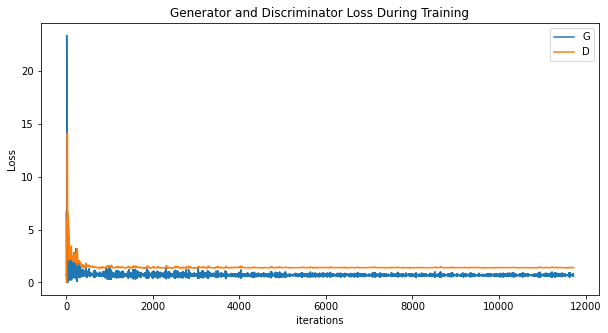

In [105]:
#  Plotting the losses
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

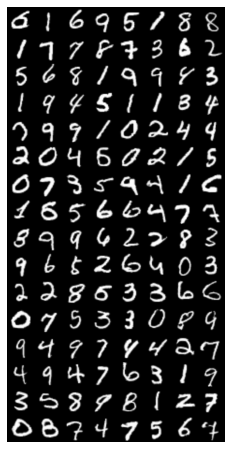

In [106]:
#Visualization of G’s progression
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())